In [1]:
import arviz as az
import daft
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy
from matplotlib.lines import Line2D
from matplotlib.patches import Ellipse
from sklearn.preprocessing import StandardScaler

import causalpy as cp
from causalpy import InstrumentalVariable
from causalpy.pymc_models import InstrumentalVariableRegression

In [2]:
%config InlineBackend.figure_format = 'retina'
seed = 42
np.random.seed(seed)

:::{note}
For this notebook we have additionally installed both `jax` and `numpyro`. This enables much quicker sampling of the posterior predictive distribution in our `InstrumentalVariable` class. You can install both by running the following commands in the jupyter notebook: 

``` 
!conda install jax
!conda install numpyro
```
:::

## Instrumental Regression and Justifying Instruments with `pymc`

The factors which determine success in schooling and subsequent employment are diverse. There are many influencing factors at play in your social demographics and individual ability. Consequently there are legitimate concerns about how the effects schooling can be cleanly assessed. Without trying to account for the confounding relationships between ability and schooling we risk biasing our results. In this example we will look into the infamous econometric question of financial returns accruing to investment in schooling. What is the expected increase in my lifetime wealth as a function of my educational attainment? The suggestion from the econometric literature is to leverage instrumental variable regression to decompose the effect of schooling on future wage acquisition. 

In particular the suggestion is that we can use an individual's (assumed as-if random) proximity to a 4-year college as an instrument. Recall that this instrument `nearcollege` has to be: (i) __relevent__,  in that it effects the causal path of interest i.e. nearness to a college is assumed to have a causal impact on an individual's `education`, (ii) __independent__, such that assignment to instrument be as good as random thereby mitigating the original selection effect bias and (iii) needs to meet the __exclusion restriction__ i.e. the instrument should influence the outcome `wage` only through the treatment of interest `education`. If these conditions are met then, we can argue that the instrumental variable regression techniques can distil the causal impact of our treatment. 

/Users/benjamv/mambaforge/envs/CausalPy/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
/Users/benjamv/mambaforge/envs/CausalPy/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


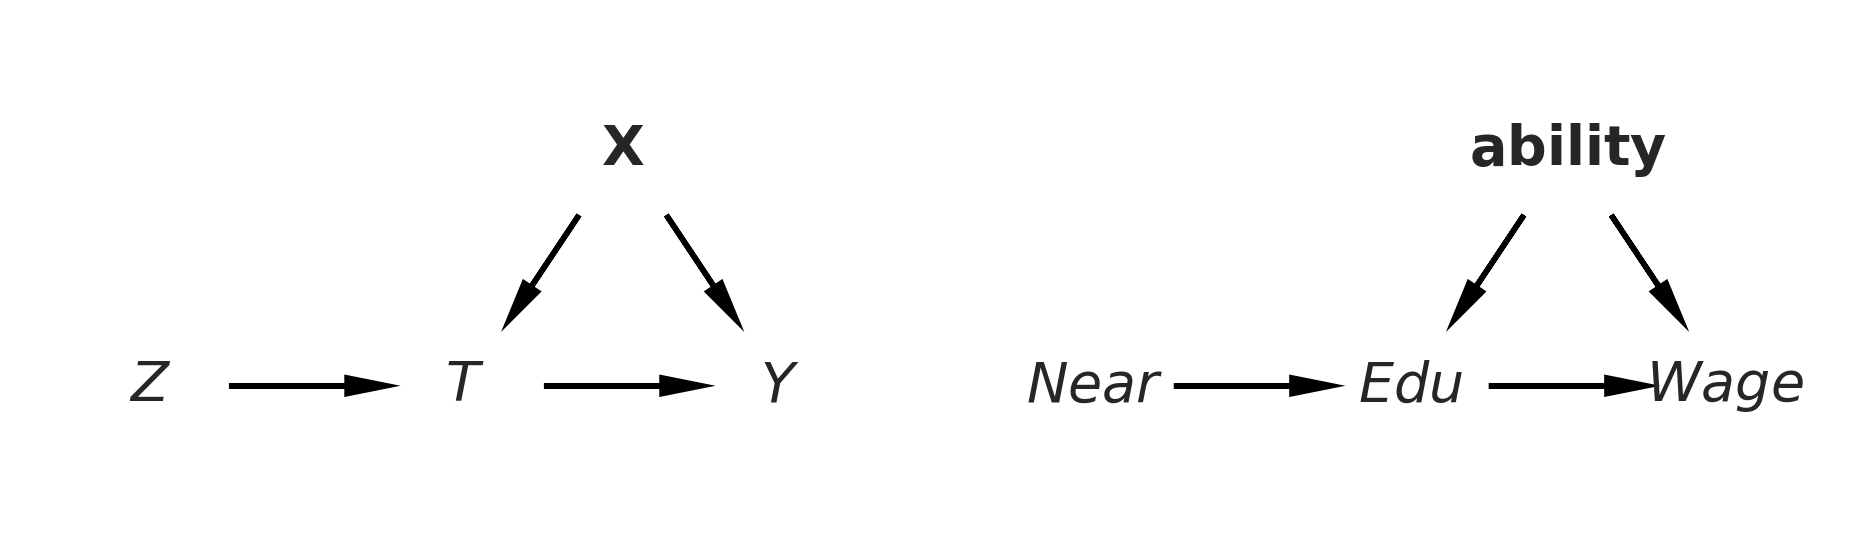

In [3]:
GRID_UNIT = 2.0
DPI = 200
NODE_EC = "none"

pgm = daft.PGM(dpi=DPI, grid_unit=GRID_UNIT, node_ec=NODE_EC)

pgm.add_node("z", "$Z$", 0, 0)
pgm.add_node("t", "$T$", 1, 0)
pgm.add_node("y", "$Y$", 2, 0)
pgm.add_node("x", "$\mathbf{X}$", 1.5, 0.75)
pgm.add_edge("z", "t")
pgm.add_edge("x", "t")
pgm.add_edge("x", "y")
pgm.add_edge("t", "y")


pgm.add_node("nearcollege", "$Near$", 3, 0)
pgm.add_node("education", "$Edu$", 4, 0)
pgm.add_node("wage", "$Wage$", 5, 0)
pgm.add_node("ability", "$\mathbf{ability}$", 4.5, 0.75)
pgm.add_edge("nearcollege", "education")
pgm.add_edge("ability", "education")
pgm.add_edge("ability", "wage")
pgm.add_edge("education", "wage")

pgm.render();

In many ways instrumental variable regression is a paradigmatic method of the [credibility revolution in econometrics](https://en.wikipedia.org/wiki/Credibility_revolution#:~:text=In%20economics%2C%20the%20credibility%20revolution,experimental%20and%20quasi%20experimental%20methods.) and the social sciences. The need to bolster credibility in the social sciences followed from the [replication crisis](https://en.wikipedia.org/wiki/Replication_crisis). Below we will explore the assumptions of the IV design and highlight the conditions under which it can be sensibly applied. First we will outline the nature of the causal estimand in IV regressions. Then we shall unpack how these estimation routines work with respect to the above assumptions. We will the show different ways of interrogating these models, comparing among similar models to argue for the crediblity of the results. 

### Regression Mechanics and Local Average Treatment Effect

The structure of an instrumental variable problem helps us get at the question of causal impact, but it does not target the typical {term}`Average treatment effect<ATE>` causal estimand. Instead we must be happy to estimate the {term}`Local Average Treatment Effect<LATE>` quantity, where we evaluate a restricted treatment effect among the "compliers" in our design. This makes sense because we are implicitly evaluating the effect of a treatment in a population where there is no guarantee of compliance. More to the point our instrument, by virtue of __independence__, is intended to induce as-if-random-assignment to the treatment within a subset of the population responsive to our instrument.  So we can't make the more general claim to have assessed change on average. It is rather an evaluation of change in the sub-population that have been induced to comply with our design. Those individuals for whom the treatment (`education`) has been influenced by our instrument (`nearcollege`).

The theory of the LATE estimator is rich. There are multiple ways of isolating the LATE quantity and multiple estimators for the LATE estimand. We show here one of the canonical presentations in terms of conditional expectations of outcome and treatment under the realisations of our instrument. 

$$\tau = LATE= \frac{E[Y | Z = 1] - E[Y | Z = 0]}{E[T | Z = 1] - E[T | Z = 0]} = \frac{\phi}{\psi} = \frac{\text{reduced form}}{\text{first stage}} $$

The last phrasing there highlights the fact that we're interested in two components of variation due to our instrument $Z$. This is one way of seeing that we're trying to estimate a __joint distribution__ of two random variables in a structural equation model. But more importantly we're assuming via __relevance__ that there is some non-trivial correlation between the realisations of the instrument $Z$, the treatment $T$. All the more important then to choose instruments relevant to the sub-population of interest or where compliance is expected to be high.

#### Digression: Sampling Multivariate Normals

How can we measure this correlation between instrument and treatment? How much correlation should we expect? In the `CausalPy` implementation of instrumental variable regression we model this correlation explicity using an LKJ Cholesky prior on a Multivariate Normal distribution. It's worth a small digression here to show how sampling from this distribution under different priors can shape the correlations of the joint-distribution. We'll show below how this offers us a mechanism to impose constraints on our beliefs about the relationships between our instruments. 

In [4]:
sd_dist = pm.Exponential.dist(1.0, shape=2)
lkj = pm.LKJCholeskyCov.dist(
    eta=2,
    n=2,
    sd_dist=sd_dist,
)
lkj1 = pm.LKJCholeskyCov.dist(
    eta=10,
    n=2,
    sd_dist=sd_dist,
)
chol, corr, sigmas = pm.draw(lkj, draws=100)
chol1, corr1, sigmas = pm.draw(lkj1, draws=100)

fig, axs = plt.subplots(4, 1, figsize=(9, 12))
axs = axs.flatten()
corrs = []
corrs1 = []
for i in range(100):
    xy = pm.draw(pm.MvNormal.dist(0, chol=chol[i]), 1000)
    xy1 = pm.draw(pm.MvNormal.dist(0, chol=chol1[i]), 1000)
    corrs.append(np.corrcoef(xy[:, 0], xy[:, 1])[0][1])
    corrs1.append(np.corrcoef(xy1[:, 0], xy1[:, 1])[0][1])

    axs[0].scatter(xy[:, 0], xy[:, 1], alpha=0.1, color="blue", rasterized=True)
    axs[1].scatter(xy1[:, 0], xy1[:, 1], alpha=0.1, color="red", rasterized=True)
    axs[2].scatter(xy[:, 0], xy[:, 1], alpha=0.1, color="blue", rasterized=True)
    axs[2].scatter(xy1[:, 0], xy1[:, 1], alpha=0.1, color="red", rasterized=True)
axs[3].hist(
    np.array(corrs),
    bins=30,
    ec="black",
    label="Correlation of Observations LKJ(eta=2)",
    color="blue",
    alpha=0.5,
    rasterized=True,
)
axs[3].hist(
    np.array(corrs1),
    bins=30,
    ec="black",
    label="Correlation of Observations LKJ(eta=10)",
    color="red",
    alpha=0.5,
    rasterized=True,
)
axs[3].legend()
axs[3].set_title("Correlation Coefficient Distribution")
axs[0].set_title("Realisations from LKJ(eta=2)")
axs[2].set_title("Overlapping Realisations")
axs[1].set_title("Realisations from LKJ(eta=10)");

In the above series of plots we have sampled from two different parameterisations of an LKJ prior probability distribution. This distribution is a prior on the expected values and covariance structure of a multivariate normal probability distribution. We have shown different parameterisations of the prior lead to more or less correlated realisations of the bivariate normal we're sampling. Here we can see that increasing the `eta` parameter on the LKJ prior shrinks the range of admissable correlations parameters. By default the `CausalPy` implementation of the `InstrumentalVariable` class samples from a bivariate normal distribution of the treatment and the outcome with a parameter setting of `eta=2`. This is worth knowing if your model makes such potential correlations very unlikely. We will show below how you can apply priors to these parameters in the instrumental variable context. 

### The Data: Returns to Schooling

We use a data set from the U.S. National Longitudinal Survey of Young Men (NLSYM) in 1976. This data was sourced from the R `ivreg` package. Originally the data is used to replicate some of the famous work from Card's 1995 paper _Using Geographical Variation in College Proximity to Estimate the Return to Schooling_ in which he aimed to distil the causal impact of education on wages. {cite:t}`card1995returns`

In [5]:
df = cp.load_data("schoolReturns")


def poly(x, p):  # replicate R's poly decompostion function
    X = np.transpose(np.vstack([x**k for k in range(p + 1)]))
    return np.linalg.qr(X)[0][:, 1:]


df["log_wage"] = np.log(df["wage"])
df[["experience_1", "experience_2"]] = pd.DataFrame(poly(df["experience"].values, 2))
df[["age_1", "age_2"]] = poly(df["age"].values, 2)
df["nearcollege_indicator"] = np.where(
    df["nearcollege"] == "yes", 1, 0
)  # 4 year college
df["nearcollege2_indicator"] = np.where(
    df["nearcollege2"] == "yes", 1, 0
)  # 2 year college
df["nearcollege4_indicator"] = np.where(
    df["nearcollege4"] == "yes", 1, 0
)  # 4 year public or private college
df["south_indicator"] = np.where(df["south"] == "yes", 1, 0)  # southern US
df["smsa_indicator"] = np.where(
    df["smsa"] == "yes", 1, 0
)  # standard metropolitan statistical area
df["ethnicity_indicator"] = np.where(
    df["ethnicity"] == "afam", 1, 0
)  # African-American or other
df[["wage", "education", "experience", "ethnicity", "nearcollege"]].head(5)

wage  education  experience ethnicity nearcollege
0   548          7          16      afam          no
1   481         12           9     other          no
2   721         12          16     other          no
3   250         11          10     other         yes
4   729         12          16     other         yes

We can split out the population by their subgroups and just look at how the outcome varies conditional on different levels of the population strata. 

In [6]:
strata_df = (
    df.assign(experience_cut=lambda x: pd.qcut(x["experience_1"], 4))
    .groupby(["nearcollege", "smsa", "ethnicity", "south", "experience_cut"])[
        ["log_wage"]
    ]
    .mean()
    .reset_index()
    .pivot(
        index=["smsa", "ethnicity", "south", "experience_cut"],
        columns="nearcollege",
        values="log_wage",
    )
    .reset_index()
    .assign(diff=lambda x: x["no"] - x["yes"])
    .sort_values("diff", ascending=False)
)
strata_df.head(10).style.background_gradient(axis=0, subset="diff")

/var/folders/pd/p2qnky2x3xl4w3mgc4lct2200000gn/T/ipykernel_3372/375102097.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["nearcollege", "smsa", "ethnicity", "south", "experience_cut"])[


In [7]:
strata_df["diff"].mean()

-0.06568303099960848

This should just highlight the magnitude of change we might expect in the outcome variable holding all else equal while naively varying the instrument status. We want next to visualise how the education and wage are related and ideally to see if and where the proximity of college seems to play a factor in that educational attainment. 

In [8]:
def rand_jitter(arr):
    stdev = 0.01 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev


custom_lines = [
    Line2D([0], [0], color="red", lw=4),
    Line2D([0], [0], color="blue", lw=4),
]


fig, axs = plt.subplots(2, 1, figsize=(10, 9))
axs = axs.flatten()
ax = axs[0]
ax1 = axs[1]
ax.set_title("Log Wage ~ Education")
col = np.where(df.nearcollege_indicator, "b", "r")
ax.scatter(
    rand_jitter(df["education"]), df["log_wage"], c=col, alpha=0.3, rasterized=True
)
ax.legend(custom_lines, ["Not NearCollege", "Near College"])
ax.set_xlabel("Education")
ax.set_ylabel("Log Wage")

x = np.linspace(0, 20, 100)
b, a = np.polyfit(df["education"], df["log_wage"], 1)
y = a + b * x

ax.plot(x, y, color="k", label="Regression Line", rasterized=True)


ellipse = Ellipse(
    (17.5, 6.5),
    width=4,
    height=2.5,
    angle=90,
    facecolor=None,
    alpha=0.1,
    color="purple",
    linestyle="--",
    rasterized=True,
)
ax.add_patch(ellipse)

custom_lines = [
    Line2D([0], [0], color="green", lw=4),
    Line2D([0], [0], color="purple", lw=4),
]
ax1.set_title("Log Wage ~ Education")
col = np.where(df.nearcollege2_indicator, "g", "purple")
ax1.plot(x, y, color="k", label="Regression Line", rasterized=True)
ellipse = Ellipse(
    (16, 6.5),
    width=4,
    height=1.5,
    angle=90,
    facecolor=None,
    alpha=0.1,
    color="blue",
    linestyle="--",
    rasterized=True,
)
ax1.add_patch(ellipse)
ax1.scatter(
    rand_jitter(df["education"]), df["log_wage"], c=col, alpha=0.6, rasterized=True
)
ax1.legend(custom_lines, ["Not Near 2 year College", "Near 2 year College"])
ax1.set_xlabel("Education")
ax1.set_ylabel("Log Wage");

There is at least some indication here that the proximity to college has an impact on educational attainment, and that education seems to drive upward the achieved wages. Typical approaches to instrumental variable regressions try to quantify the strength of the instrument formally. But even visually here the evidence that proximity to college would induce increased levels of education seems compelling. For instance, we see a clear upward sloping trend relationship between educational attainment and wage-acquisition. But additionally, in the first plot we can see a sparse presence of individuals who achieved the maximum educational outcomes among those with poor proximity to 4 year colleges i.e. fewer red dots than blue in the ellipses. A similar story plays out in the second plot but focused on the maximal educational attainment assuming the proxmity of a 2 year college. These observations should tilt our view of the conditional expectations for wage growth based on proximty to college. 

### Justificatory Models

We start with the simple regression context. This serves two purposes: (i) we can explore how the effect of `education` is measured in a simple regression and we can (ii) benchmark the efficacy of our instrument `nearcollege_indcator` in the context of trying to predict `education`. These regressions are effectively diagnostic tests of our instrument. In what follows we'll look seperately at

- (i) the first stage regression of the LATE estimate, 
- (ii) the reduced form regression and 
- (iii) the Wald estimate of the LATE quantity which results from (i) and (ii). 
- (iv) comparing (iii) with the simple regression adjustment estimates of the effect of schooling. 

#### The First Stage

By fitting the first stage regression we can evaluate the __relevance__ assumption. This assumption is testable in that we want to be sure that the coefficient weight accorded to our instrument is not 0, and thereby show that the inclusion of the instrument can help predict some of the variance in the treatment. It is standard to include a F-test style check to help argue that your instrument indeed warrants being included in your understanding of the treatment. We show how to perform this exercise below. 

Let's first look at how this works when we add demographic controls to our regression. 

In [9]:
covariate_df = df[
    [
        "experience_1",
        "experience_2",
        "ethnicity_indicator",
        "smsa_indicator",
        "south_indicator",
        "nearcollege_indicator",
    ]
].copy()
covariate_df["Intercept"] = 1
covariate_df = covariate_df[
    [
        "Intercept",
        "experience_1",
        "experience_2",
        "ethnicity_indicator",
        "smsa_indicator",
        "south_indicator",
        "nearcollege_indicator",
    ]
]


def make_reg_model(covariate_df, target="log_wage", prior_beta=[0, 1]):
    coords = {"covariates": list(covariate_df.columns)}
    with pm.Model(coords=coords) as reg_model:
        X = pm.Data("X", covariate_df)
        beta = pm.Normal("beta_z", prior_beta[0], prior_beta[1], dims="covariates")
        mu = pm.Deterministic("mu", pm.math.dot(X, beta))
        sigma = pm.TruncatedNormal("sigma", 1, lower=0.005)
        _ = pm.Normal("likelihood", mu, sigma, observed=df[target].values)
        idata_reg = pm.sample_prior_predictive()
        idata_reg.extend(
            pm.sample(
                nuts_sampler="numpyro",
                target_accept=0.99,
                idata_kwargs={"log_likelihood": True},
            )
        )  ## requires Jax and Numpyro install
    return reg_model, idata_reg


first_stage_model, idata_first_stage = make_reg_model(covariate_df, target="education")

Sampling: [beta_z, likelihood, sigma]


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

We can now pull out the parameter estimates for our first stage model which shows a positive beta coefficient `beta_z[nearcollege_indicator]` indicating that our instrument is indeed useful in predicting the `education` metric. 

In [10]:
az.summary(idata_first_stage, var_names=["beta_z"])[
    ["mean", "sd", "hdi_3%", "hdi_97%", "r_hat"]
]

mean     sd  hdi_3%  hdi_97%  r_hat
beta_z[Intercept]              12.832  0.108  12.624   13.037    1.0
beta_z[experience_1]           13.021  0.978  11.173   14.852    1.0
beta_z[experience_2]           -0.194  0.887  -1.861    1.487    1.0
beta_z[ethnicity_indicator]    -1.365  0.108  -1.574   -1.170    1.0
beta_z[smsa_indicator]          0.850  0.102   0.650    1.029    1.0
beta_z[south_indicator]        -0.374  0.097  -0.551   -0.187    1.0
beta_z[nearcollege_indicator]   0.400  0.103   0.213    0.595    1.0

Here we apply F-test style logic to evaluate the proportion of variance explained by our model differs from the intercept only (or null model). This test arises because we can reject the null whenever the `F_stat` implied by our model is an extreme outlier on the F-distribution implied by our null-hypothesis. 

In [11]:
def make_F_test(idata, df, df_mod=6, df_res=3003, param="beta_z"):
    covariates = list(idata["posterior"][param]["covariates"].values)
    temp = df.copy()
    temp["Intercept"] = 1
    covariate_df = temp[covariates]
    params = az.extract(idata["posterior"][param])[param]
    preds = np.dot(covariate_df, params.mean(axis=1))
    resids = df["education"] - preds
    ss_res = np.sum(np.square(resids))
    ## Intercept Only model
    ss_tot = np.sum((df["education"] - np.mean(df["education"])) ** 2)
    ss_mod = ss_tot - ss_res
    ss_mod = ss_mod / df_mod
    ss_res = ss_res / df_res
    F_stat = ss_mod / ss_res
    p_value = np.round(scipy.stats.f.sf(F_stat, df_mod, df_res), 5)
    test = {
        True: "less than the Alpha value of 0.05 meaning we can reject the Null Hypothesis",
        False: "greater than the Alpha value of 0.05 meaning we cannot reject the Null Hypothesis",
    }
    result = f"""The F-Stat: {F_stat} implies a p-values of {p_value} \nwhich is {test[p_value < 0.05]}"""
    print(result)
    return F_stat, p_value


F_stat, p_value = make_F_test(idata_first_stage, df)

The F-Stat: 133.550496512908 implies a p-values of 0.0 
which is less than the Alpha value of 0.05 meaning we can reject the Null Hypothesis


This at least suggests some evidence that the __instrument + controls__ are relevant to the treatment. You may worry that too much of this explained variance is due to the controls, so we can pull out the individual instrument and perform the same test with the single instrument. 

In [12]:
first_stage_model_instrument, idata_first_stage_instrument = make_reg_model(
    covariate_df[["Intercept", "nearcollege_indicator"]], target="education"
)
az.summary(idata_first_stage_instrument, var_names=["beta_z"])[
    ["mean", "sd", "hdi_3%", "hdi_97%", "r_hat"]
]

Sampling: [beta_z, likelihood, sigma]


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

mean     sd  hdi_3%  hdi_97%  r_hat
beta_z[Intercept]              12.611  0.084  12.448   12.761    1.0
beta_z[nearcollege_indicator]   0.912  0.101   0.727    1.108    1.0

In [13]:
F_stat, p_value = make_F_test(idata_first_stage_instrument, df)

The F-Stat: 10.458004475047499 implies a p-values of 0.0 
which is less than the Alpha value of 0.05 meaning we can reject the Null Hypothesis


Here we can still reject the null at any level. There have been various thresholds put forward in the literature based on simulation studies for when we should deem an instrument "strong" enough, but these are crude rules of thumb and should not be relied on to defend your design. We want to justify our instrument theoretically and ensure that it is well-identified in the first stage regression. In the Bayesian setting we want to know how the prior/posterior update step has shifted our distribution.

In [14]:
az.plot_dist_comparison(
    idata_first_stage,
    var_names=["beta_z"],
    coords={"covariates": ["nearcollege_indicator"]},
    figsize=(8, 4),
);

Bayesian updating has meaningfully shifted the posterior distribution from the prior realisations by incorporating the evidence in the data. We will continue to build models including these demographic controls features, but the focus remains the instruments and their justification. 

#### The Reduced Form

While in the case of __relevance__ we can aim to justify our assumptions as above, but with the __exclusion restriction__ assumption we cannot directly test the claim. Remember we're arguing that the influence of our instrument $Z$ impacts our outcome $Y$ only through the treatment $T$. In our case this means that the exclusion restriction assumption would be violated if proximity to college had an impact on earnings independent of the mediating effect of schooling. This is presumably not impossible. For `nearcollege` to impact `wage` through a mechanism not related to `education` one would have to posit that there is some driver of wage growth or degradation influenced by proximity to education. You might argue that the density of business investment is clustered near educational hubs, so indirectly even if you didn't go to college and directly receive education your wage is function of the education of local peers. Is this an acceptable edge-case? Is it borne out by the majority distribution of colleges within urban centres? These are the kinds of questions we need be concerned with as we assess the relationship between our instrument and our outcome. 

Next we fit the reduced form model which predicts our outcome on the basis of our control variables, our instrument but removes the treatment. 

In [15]:
reduced_form_model, idata_reduced_form = make_reg_model(covariate_df, target="log_wage")
az.summary(idata_reduced_form["posterior"]["beta_z"])[
    ["mean", "sd", "hdi_3%", "hdi_97%", "r_hat"]
]

Sampling: [beta_z, likelihood, sigma]


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

mean     sd  hdi_3%  hdi_97%  r_hat
beta_z[Intercept]              6.218  0.018   6.184    6.254    1.0
beta_z[experience_1]          -1.962  0.382  -2.721   -1.275    1.0
beta_z[experience_2]           2.211  0.366   1.490    2.859    1.0
beta_z[ethnicity_indicator]   -0.261  0.019  -0.297   -0.227    1.0
beta_z[smsa_indicator]         0.185  0.018   0.152    0.218    1.0
beta_z[south_indicator]       -0.143  0.017  -0.176   -0.113    1.0
beta_z[nearcollege_indicator]  0.045  0.017   0.014    0.079    1.0

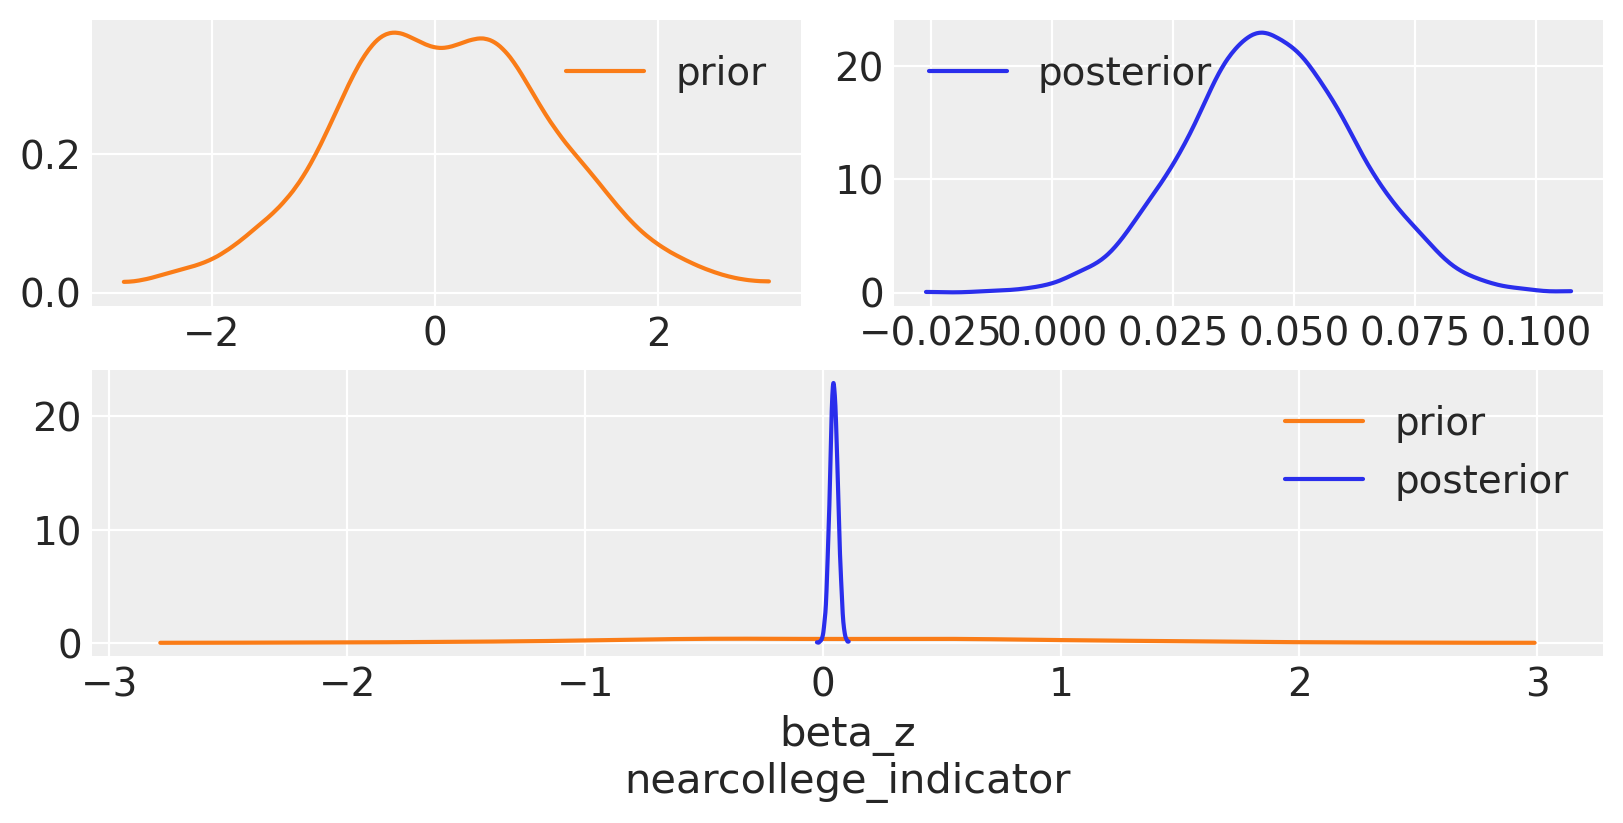

In [16]:
az.plot_dist_comparison(
    idata_reduced_form,
    var_names=["beta_z"],
    coords={"covariates": ["nearcollege_indicator"]},
    figsize=(8, 4),
);

Here the reduced form regression indicates a parameter estimate quite close to zero suggesting at least in the task of predicting log-wages we should see the predictive impact of proximity absorbed into the `education` variable when it is included in our IV model.

#### The Wald Estimate

These exploratory regressions give us an understanding of the dynamics at play in an instrumental variable set up, but we also get (for free) a means of calculating the LATE quantity by means of the Wald estimation routine. 

In [17]:
reduced = az.extract(idata_reduced_form["posterior"])["beta_z"].sel(
    covariates="nearcollege_indicator"
)
first = az.extract(idata_first_stage["posterior"])["beta_z"].sel(
    covariates="nearcollege_indicator"
)
estimate = reduced / first
estimate.mean().data

array(0.12332167)

Which is to say that the Wald estimate implies 0.12 in the log-wage for an additional year in education. We'll translate this to the raw outcome scale below.  

### Wald Estimate Versus Simple Controlling Regression

But now we can compare this estimate to the regression achieved with a simpler regression that just includes `education` as a control. 

In [18]:
naive_reg_model, idata_reg = make_reg_model(
    covariate_df.assign(education=df["education"])
)
az.summary(idata_reg, var_names=["beta_z"])[
    ["mean", "sd", "hdi_3%", "hdi_97%", "r_hat"]
]

Sampling: [beta_z, likelihood, sigma]


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

mean     sd  hdi_3%  hdi_97%  r_hat
beta_z[Intercept]              5.348  0.048   5.257    5.436    1.0
beta_z[experience_1]          -7.203  0.452  -8.049   -6.332    1.0
beta_z[experience_2]           2.324  0.348   1.688    3.004    1.0
beta_z[ethnicity_indicator]   -0.191  0.018  -0.226   -0.159    1.0
beta_z[smsa_indicator]         0.154  0.016   0.126    0.187    1.0
beta_z[south_indicator]       -0.122  0.015  -0.151   -0.095    1.0
beta_z[nearcollege_indicator]  0.023  0.016  -0.007    0.053    1.0
beta_z[education]              0.067  0.003   0.060    0.073    1.0

Here we see how a regression which includes our instrument and our treatment sees the coefficient weight accorded to our instrument `beta_z[nearcollege_indicator]` shrink further towards 0. This is somewhat suggestive that the __exclusion restriction__ remains plausible. The effect of our instrument is absorbed into the more direct influence of treatment variable. 

In [19]:
ols_estimate = az.extract(idata_reg["posterior"])["beta_z"].sel(covariates="education")
fig, axs = plt.subplots(2, 1, figsize=(7, 9))
axs = axs.flatten()
ax = axs[0]
ax1 = axs[1]
ax.hist(
    estimate,
    bins=30,
    ec="black",
    alpha=0.5,
    label=r"IV $\beta$ Education",
    rasterized=True,
)
ax1.hist(
    ols_estimate,
    bins=30,
    ec="black",
    alpha=0.5,
    label=r"Simple $\beta$ Education",
    color="red",
    rasterized=True,
)
ax.axvline(
    np.mean(estimate),
    linestyle="--",
    color="k",
    label=f"Expected IV Estimate: {np.round(np.mean(estimate.values), 2)}",
)
ax1.axvline(
    np.mean(ols_estimate),
    linestyle="--",
    color="k",
    label=f"Expected: {np.round(np.mean(ols_estimate.values), 2)}",
)
ax1.set_xlabel(r"$\beta$ coefficient Education")

ax.legend()
ax1.legend(loc="upper left")
ax.set_title(
    "Estimated IV Effect \n  Returns to Schooling",
)
ax1.set_title("Estimated Simple Effect \n  Returns to Schooling");

Note here the marked difference in magnitude between the naive regression and the instrumental variable estimates. This contrast is in many ways at the heart of the the IV design. By proposing an IV model for our problem we're arguing that the difference in the simple regression and IV estimate is due to the influence of confounder which warps our understanding of the treatment on the outcome. The IV design is intended to remove this warping effect. Understanding the magnitude of the difference in these estimates gives some sense of the work done by the supposed confounding variable. 

### CausalPy and Multivariate Models

Now we fit the models using CausalPy's Bayesian instrumental variable regression. Here we can explicitly state the structural equations that make up our model. Importantly we ensure that the control variables included in the instrument formula are also in included in the outcome formula.

In [20]:
sample_kwargs = {
    "chains": 4,
    "cores": 4,
    "target_accept": 0.95,
    "progressbar": True,
    "nuts_sampler": "numpyro",  ## requires Jax and Numpyro install
    "idata_kwargs": {"log_likelihood": True},
}
instruments_formula = "education ~ 1 + experience_1 + experience_2 + ethnicity_indicator + south_indicator + smsa_indicator + nearcollege_indicator"
formula = "log_wage ~ 1 + education  + experience_1 + experience_2 + ethnicity_indicator + south_indicator + smsa_indicator"
instruments_data = df[
    [
        "education",
        "nearcollege_indicator",
        "experience_1",
        "experience_2",
        "ethnicity_indicator",
        "smsa_indicator",
        "south_indicator",
    ]
]
data = df[
    [
        "log_wage",
        "education",
        "experience_1",
        "experience_2",
        "ethnicity_indicator",
        "smsa_indicator",
        "south_indicator",
    ]
]
iv = InstrumentalVariable(
    instruments_data=instruments_data,
    data=data,
    instruments_formula=instruments_formula,
    formula=formula,
    model=InstrumentalVariableRegression(sample_kwargs=sample_kwargs),
)

az.summary(iv.idata, var_names=["beta_t", "beta_z"])[
    ["mean", "sd", "hdi_3%", "hdi_97%", "r_hat"]
]

/Users/benjamv/git/CausalPy/causalpy/data_validation.py:143: UserWarning: Warning. The treatment variable is not Binary.
                This is not necessarily a problem but it violates
                the assumption of a simple IV experiment.
                The coefficients should be interpreted appropriately.
  warnings.warn(


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

mean     sd  hdi_3%  hdi_97%  r_hat
beta_t[Intercept]              13.097  0.087  12.933   13.262    1.0
beta_t[experience_1]           89.860  0.908  88.138   91.560    1.0
beta_t[experience_2]           -0.881  0.871  -2.539    0.677    1.0
beta_t[ethnicity_indicator]    -1.006  0.088  -1.159   -0.828    1.0
beta_t[south_indicator]        -0.290  0.081  -0.446   -0.146    1.0
beta_t[smsa_indicator]          0.405  0.082   0.250    0.556    1.0
beta_t[nearcollege_indicator]   0.338  0.080   0.191    0.487    1.0
beta_z[Intercept]               4.503  0.152   4.213    4.786    1.0
beta_z[education]               0.131  0.011   0.110    0.153    1.0
beta_z[experience_1]          -14.063  0.955 -15.968  -12.400    1.0
beta_z[experience_2]            2.696  0.354   2.072    3.379    1.0
beta_z[ethnicity_indicator]    -0.132  0.021  -0.171   -0.091    1.0
beta_z[south_indicator]        -0.105  0.016  -0.137   -0.076    1.0
beta_z[smsa_indicator]          0.132  0.017   0.101    0.164    1.0

#### The Coefficients of Interest

As we can see here the `beta_z[education]` coefficient records our LATE estimate and recovers substantially the same value as our 2 step Wald estimate above. Note also how the `experience_1` variable appears to be on a different magnitude than the other variables. 

By default the `InstrumentalVariable` class does not sample from the prior predictive or the posterior predictive distribution as in a typical `CausalPy` model. This is largely because the primary focus in IV regression is that the focus is on the `beta_z`, and `beta_t` parameters and in the focal parameter on the treatment effect recorded against `beta_z[education]`. 

However it is entirely possible to sample the posterior predictive distribution in a post-model estimation step. If you do wish to sample the posterior predictive distribution, we __strongly__ recommend installing and using the Jax sampler for the posterior predictive sampling as it can be considerably faster than the base pymc sampler. 

In [21]:
iv.model.sample_predictive_distribution(ppc_sampler="jax")

/Users/benjamv/mambaforge/envs/CausalPy/lib/python3.11/site-packages/pytensor/link/jax/linker.py:28: UserWarning: The RandomType SharedVariables [RandomGeneratorSharedVariable(<Generator(PCG64) at 0x3654C2960>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [likelihood]


Output()

As before we can also pull out the prior predictive checks and observe the manner in which the posterior distribution has updated our prior.

Sampling: [beta_z]


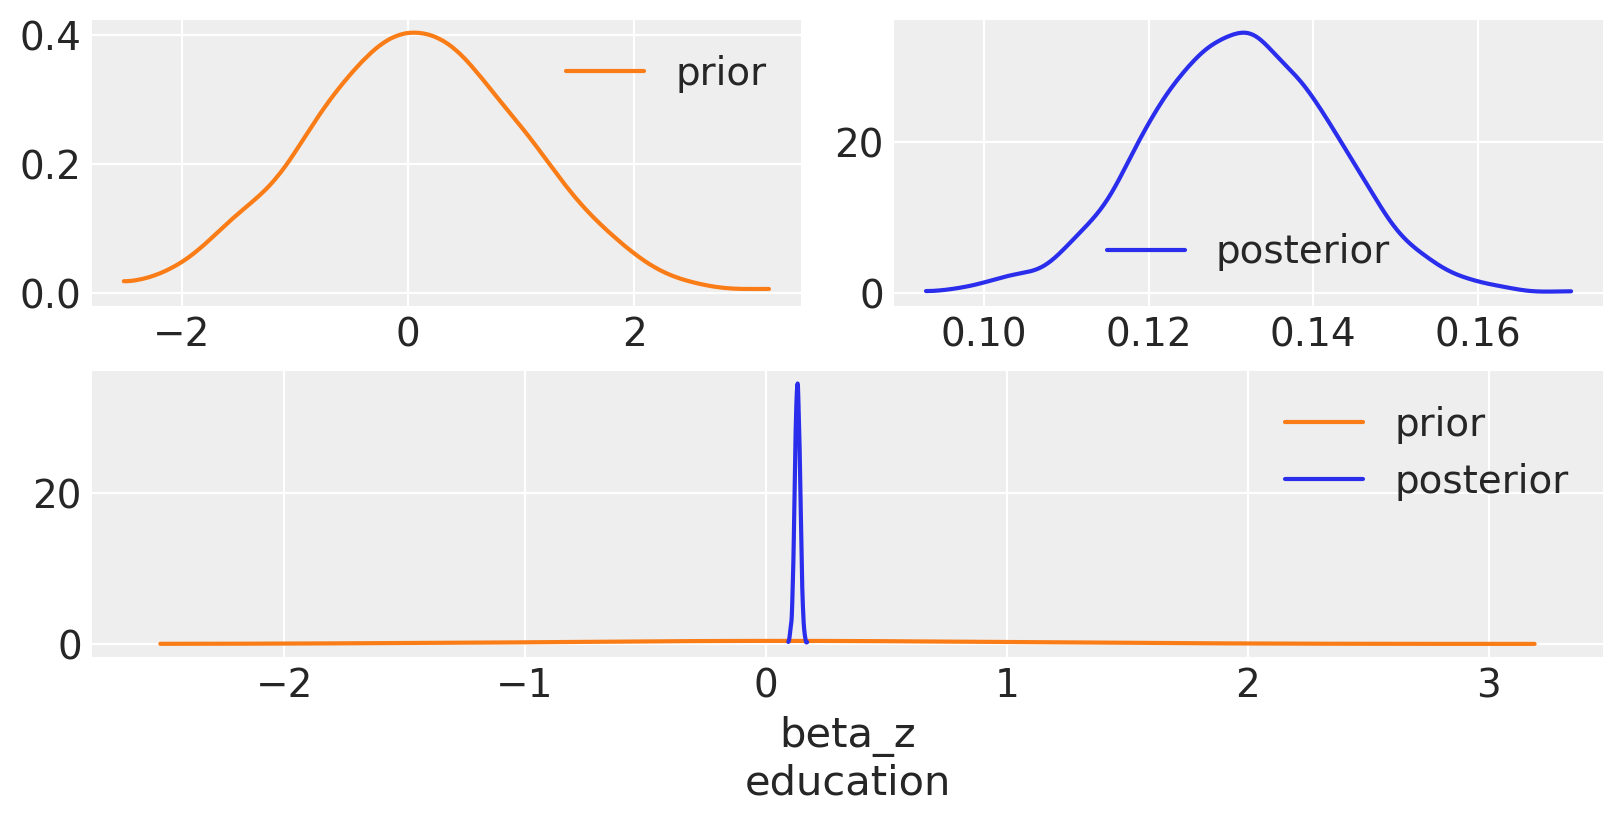

In [22]:
with iv.model:
    iv.idata.extend(pm.sample_prior_predictive(var_names=["beta_z"]))
az.plot_dist_comparison(
    iv.idata, var_names=["beta_z"], coords={"covariates": ["education"]}, figsize=(8, 4)
);

The above plot shows how broadly we assumed the possible realisations of the treatment effect could be, and how narrowly the plausible realisations are in light of the observed data. 

#### Complicating the Instrument Formula

We can further evaluate the idea of strengthening the instrument effect by adding additional instruments. A natural idea is to see how the instrumented values of the `education` equation vary when we add the additional `nearcollege2_indicator`. From our visual inspection of the data it seemed like there would be some value to trying to determine how proximity to both 2 and 4 year colleges drive educational attainment. 

In [23]:
instruments_formula = """education ~  experience_1 + experience_2 + ethnicity_indicator + south_indicator + 
                                      smsa_indicator + nearcollege_indicator + nearcollege2_indicator"""

formula = "log_wage ~ 1 + education  + experience_1 + experience_2 + ethnicity_indicator + south_indicator + smsa_indicator"

instruments_data = df[
    [
        "education",
        "nearcollege_indicator",
        "nearcollege2_indicator",
        "experience_1",
        "experience_2",
        "ethnicity_indicator",
        "smsa_indicator",
        "south_indicator",
    ]
]

data = df[
    [
        "log_wage",
        "education",
        "experience_1",
        "experience_2",
        "ethnicity_indicator",
        "smsa_indicator",
        "south_indicator",
    ]
]
iv1 = InstrumentalVariable(
    instruments_data=instruments_data,
    data=data,
    instruments_formula=instruments_formula,
    formula=formula,
    model=InstrumentalVariableRegression(sample_kwargs=sample_kwargs),
)
iv1.model.sample_predictive_distribution(ppc_sampler="jax")

az.summary(iv1.idata, var_names=["beta_t", "beta_z"])[
    ["mean", "sd", "hdi_3%", "hdi_97%", "r_hat"]
]

/Users/benjamv/git/CausalPy/causalpy/data_validation.py:143: UserWarning: Warning. The treatment variable is not Binary.
                This is not necessarily a problem but it violates
                the assumption of a simple IV experiment.
                The coefficients should be interpreted appropriately.
  warnings.warn(


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

/Users/benjamv/mambaforge/envs/CausalPy/lib/python3.11/site-packages/pytensor/link/jax/linker.py:28: UserWarning: The RandomType SharedVariables [RandomGeneratorSharedVariable(<Generator(PCG64) at 0x3209F8F20>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [likelihood]


Output()

mean     sd  hdi_3%  hdi_97%  r_hat
beta_t[Intercept]               13.057  0.088  12.894   13.222    1.0
beta_t[experience_1]            89.916  0.868  88.241   91.560    1.0
beta_t[experience_2]            -0.800  0.894  -2.417    0.924    1.0
beta_t[ethnicity_indicator]     -1.019  0.090  -1.186   -0.850    1.0
beta_t[south_indicator]         -0.275  0.078  -0.419   -0.127    1.0
beta_t[smsa_indicator]           0.389  0.084   0.228    0.544    1.0
beta_t[nearcollege_indicator]    0.307  0.076   0.165    0.444    1.0
beta_t[nearcollege2_indicator]   0.154  0.066   0.033    0.280    1.0
beta_z[Intercept]                4.116  0.155   3.830    4.409    1.0
beta_z[education]                0.160  0.012   0.138    0.181    1.0
beta_z[experience_1]           -16.676  0.980 -18.477  -14.813    1.0
beta_z[experience_2]             2.718  0.355   2.034    3.376    1.0
beta_z[ethnicity_indicator]     -0.102  0.022  -0.145   -0.060    1.0
beta_z[south_indicator]         -0.096  0.017  -0.128   -0.064    1.0
beta_z[smsa_indicator]           0.117  0.018   0.082    0.149    1.0

Here we see how the inclusion of the extra instrument `beta_t[nearcollege2_indicator]` and the original instrument `beta_t[nearcollege_indicator]` has pushed the LATE estimate up from .13 to .16. This is at least intuitively plausible and perhaps lends strength to the overall idea that proximity is a good instrument.

### Credible Inference and the Credibility Revolution.

How far can we push the idea? How vulnerable is our inference to model mis-specification? Can we stress test the parameter estimates by trying strong priors? The IV methodology is palpably about argument - credible argument for the proposed mechanism. With this in mind, one benefit of the Bayesian modelling approach to IV is that we can express and stretch the credibility of the mechanism in our model design. We can stress-test the credibility of inferences by trying to impose __contestable__ beliefs as priors on the model and see the degree to which the inferences are anchored by our prior specifications and how much the data pulls us away from more incredible postulates. 

Here we'll refit our original IV model, but we'll scale the `experience_1` variable to have a mean of 0. This allows us to place priors of roughly the same scale on all variables. 

In [24]:
instruments_formula = """education ~ experience_1 + experience_2 + ethnicity_indicator + south_indicator + 
                                      smsa_indicator + nearcollege_indicator
                                      """
formula = "log_wage ~ 1 + education + experience_1 + experience_2 + ethnicity_indicator + south_indicator + smsa_indicator"
instruments_data = df[
    [
        "education",
        "nearcollege_indicator",
        "experience_1",
        "experience_2",
        "ethnicity_indicator",
        "smsa_indicator",
        "south_indicator",
    ]
]
data = df[
    [
        "log_wage",
        "education",
        "experience_1",
        "experience_2",
        "ethnicity_indicator",
        "smsa_indicator",
        "south_indicator",
    ]
]

scaler = StandardScaler()
data["experience_1"] = scaler.fit_transform(data[["experience_1"]])
instruments_data["experience_1"] = scaler.fit_transform(
    instruments_data[["experience_1"]]
)
data[["log_wage", "education", "experience_1", "experience_2"]].head(5)

/var/folders/pd/p2qnky2x3xl4w3mgc4lct2200000gn/T/ipykernel_3372/3212762373.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["experience_1"] = scaler.fit_transform(data[["experience_1"]])
/var/folders/pd/p2qnky2x3xl4w3mgc4lct2200000gn/T/ipykernel_3372/3212762373.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  instruments_data["experience_1"] = scaler.fit_transform(


log_wage  education  experience_1  experience_2
0  6.306275          7     -1.725159     -0.016329
1  6.175867         12     -0.034739      0.014776
2  6.580639         12     -1.725159     -0.016329
3  5.521461         11     -0.276228      0.015422
4  6.591674         12     -1.725159     -0.016329

We will then modify our prior for the LATE estimate upward to .2. Trying to pull the inference up for the sake of argument. 

In [25]:
modified = iv.ols_beta_second_params
modified[1] = 0.20
modified[2] = 0
modified[3] = 0
modified

[4.486489832009674,
 0.2,
 0,
 0,
 -0.13080191375573674,
 -0.10490054155737207,
 0.13132367504470194]

In [26]:
modified_first = iv.ols_beta_first_params
modified_first[1] = 0
modified_first

[13.098074632594448,
 0,
 -0.8633797925737376,
 -1.0061382678610173,
 -0.29146401700569985,
 0.40387687667134015,
 0.33732078008876376]

Additionally we'll constrain the possible correlations we believe acceptable by upping the `eta` parameter and shrinking the standard deviations of the multivariate normal. 

In [27]:
iv2 = InstrumentalVariable(
    instruments_data=instruments_data,
    data=data,
    instruments_formula=instruments_formula,
    formula=formula,
    model=InstrumentalVariableRegression(sample_kwargs=sample_kwargs),
    priors={
        "mus": [modified_first, modified],
        "sigmas": [1, 1],
        "eta": 10,
        "lkj_sd": 0.5,
    },
)

az.summary(iv2.idata, var_names=["beta_t", "beta_z"])[
    ["mean", "sd", "hdi_3%", "hdi_97%", "r_hat"]
]

/Users/benjamv/git/CausalPy/causalpy/data_validation.py:143: UserWarning: Warning. The treatment variable is not Binary.
                This is not necessarily a problem but it violates
                the assumption of a simple IV experiment.
                The coefficients should be interpreted appropriately.
  warnings.warn(


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

mean     sd  hdi_3%  hdi_97%  r_hat
beta_t[Intercept]              13.097  0.090  12.919   13.257   1.00
beta_t[experience_1]            1.636  0.035   1.574    1.707   1.00
beta_t[experience_2]           -0.796  0.918  -2.531    0.959   1.00
beta_t[ethnicity_indicator]    -1.006  0.089  -1.170   -0.840   1.00
beta_t[south_indicator]        -0.289  0.081  -0.439   -0.135   1.00
beta_t[smsa_indicator]          0.405  0.086   0.241    0.565   1.00
beta_t[nearcollege_indicator]   0.337  0.080   0.192    0.492   1.00
beta_z[Intercept]               4.868  0.412   4.059    5.572   1.01
beta_z[education]               0.104  0.031   0.050    0.165   1.01
beta_z[experience_1]           -0.211  0.051  -0.307   -0.118   1.01
beta_z[experience_2]            2.330  0.350   1.701    3.020   1.00
beta_z[ethnicity_indicator]    -0.160  0.036  -0.227   -0.093   1.00
beta_z[south_indicator]        -0.116  0.019  -0.150   -0.081   1.00
beta_z[smsa_indicator]          0.147  0.023   0.106    0.191   1.00

We see here that the LATE estimate `beta_z[education]` has shrunk from the values recorded in the previous models, but still remains consistently higher than the estimate achieved by looking at a simple controlling regression. 

### Comparing Model Inferences

Just to make the emerging picture clearer we pull out and plot the credible intervals for the parameter estimates implied by each model. Here we can see the different implications induced by each model configuration. Note how all the IV models pull the credible intervals away from the simpler OLS type model estimate. 

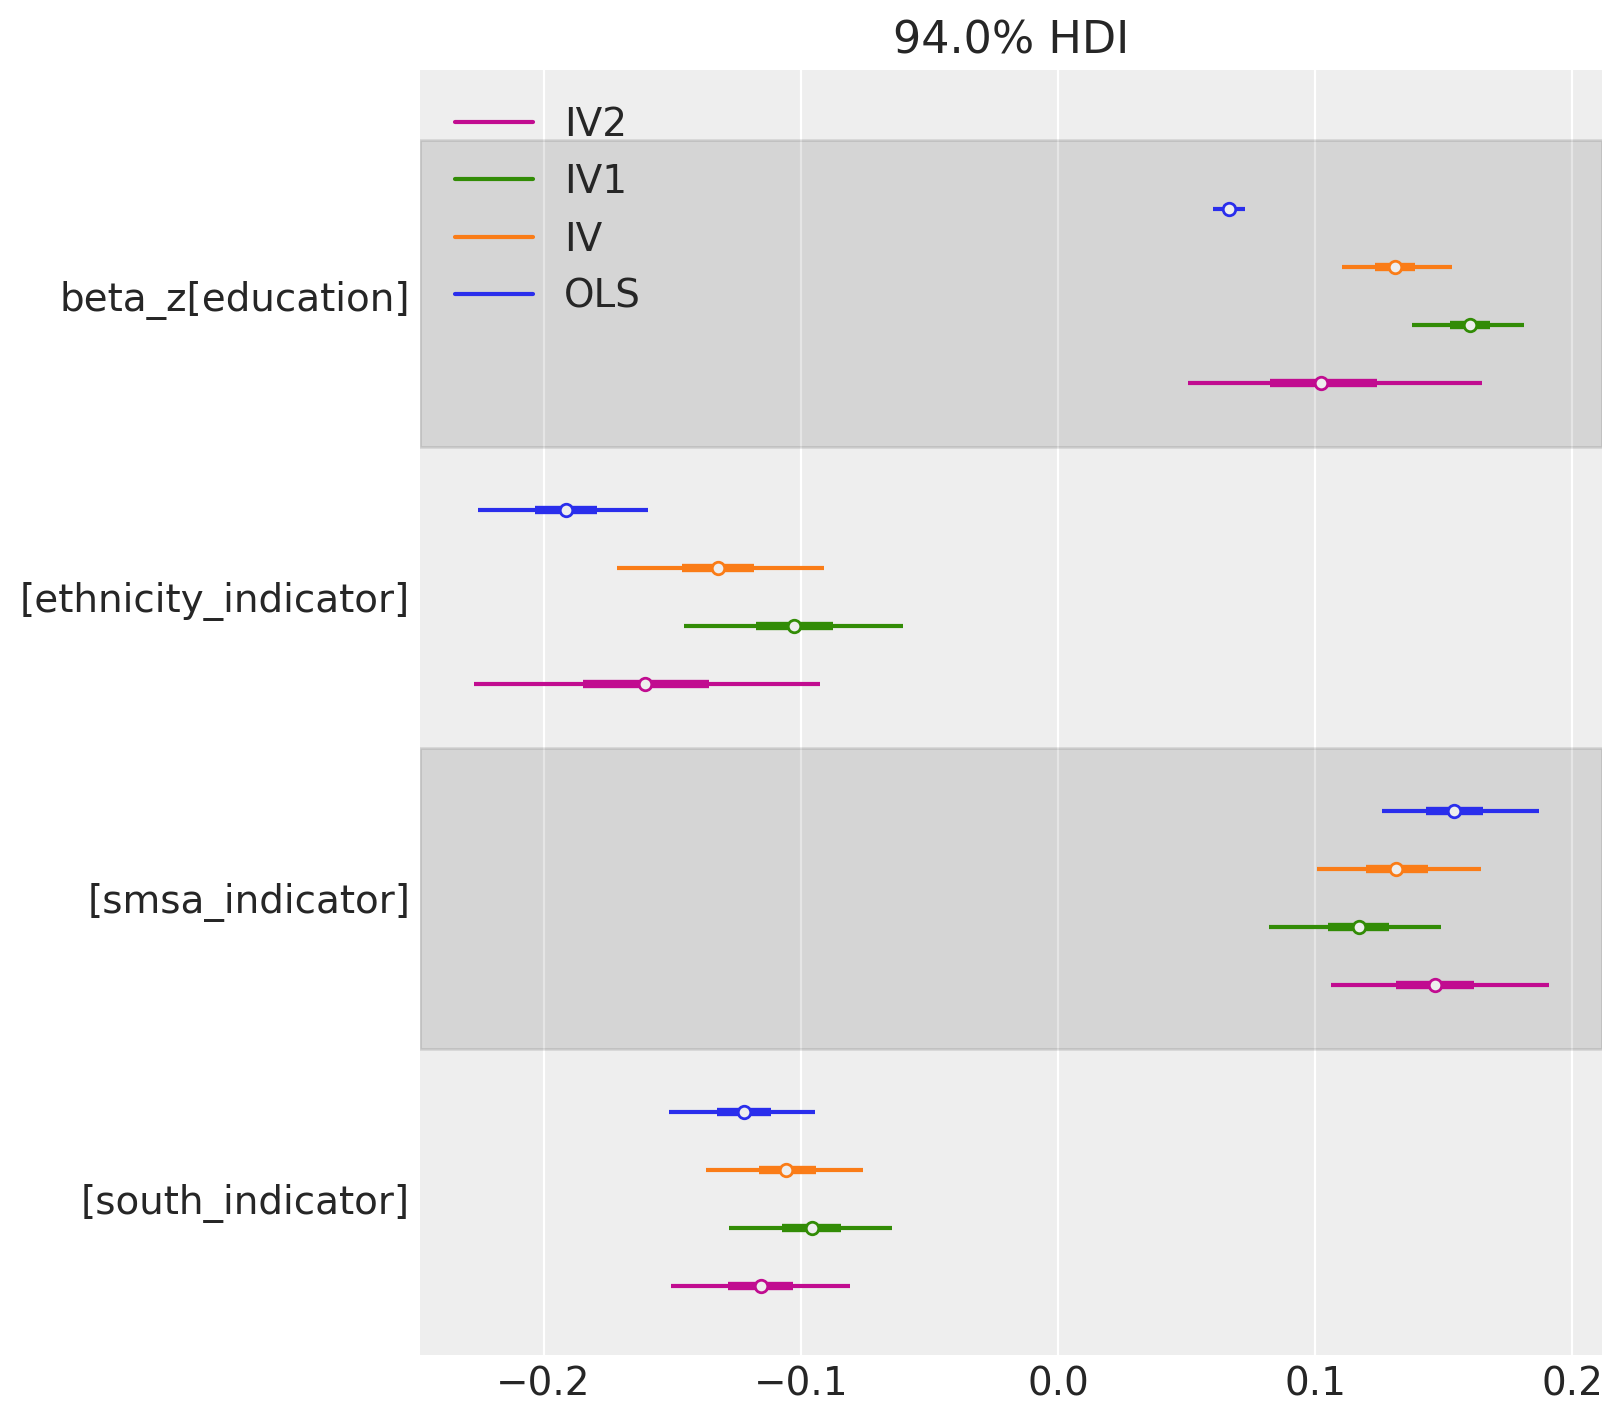

In [28]:
az.plot_forest(
    [idata_reg, iv.idata, iv1.idata, iv2.idata],
    var_names=["beta_z"],
    coords={
        "covariates": [
            "education",
            "ethnicity_indicator",
            "smsa_indicator",
            "south_indicator",
        ]
    },
    combined=True,
    model_names=["OLS", "IV", "IV1", "IV2"],
    figsize=(8, 7),
);

The increased uncertainty in our final model is being driven by uncertainty in the correlation parameters. But despite our attempt to pull the LATE estimate upwards the process of Bayesian updating pulled the HDI of our credibility interval into a perfectly reasonable range overlapping considerably with our first IV fit. 

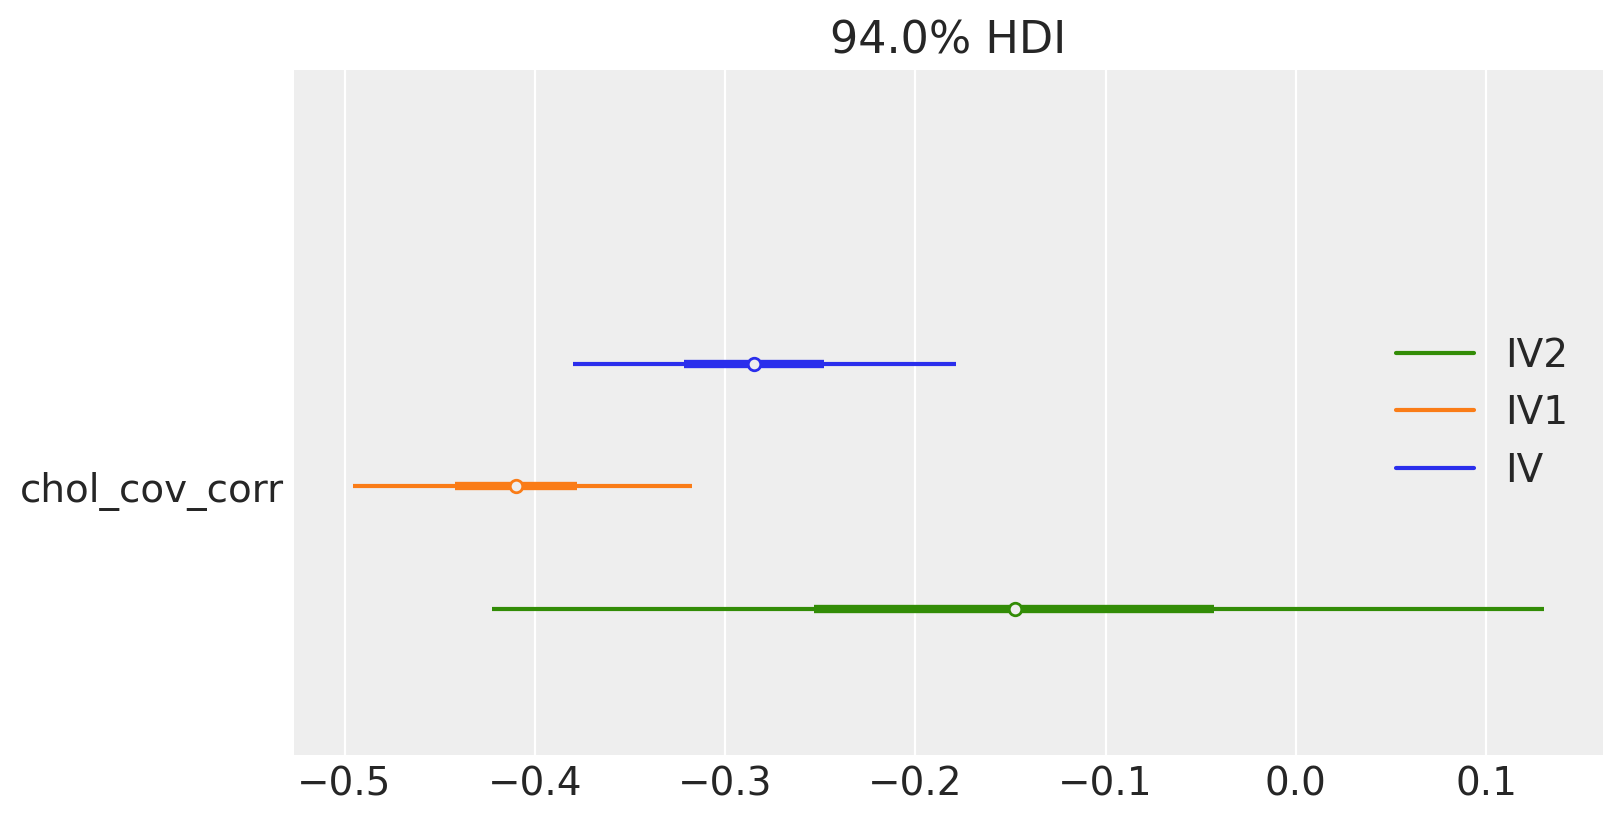

In [29]:
az.plot_forest(
    [iv.idata, iv1.idata, iv2.idata],
    var_names=["chol_cov_corr"],
    coords={"chol_cov_corr_dim_1": [1], "chol_cov_corr_dim_0": [0]},
    combined=True,
    model_names=["IV", "IV1", "IV2"],
    figsize=(8, 4),
);

The uncertainty in the correlation implied in the last model kind of undermines this model specification. If our argument about the instrument is to be compelling we would expect __relevance__ to hold. A model specification which degrades the relevance by means of reduced correlation is perhaps too extreme. We have in effect degraded the relevance of our instrument and still recover a strong positive effect for `beta_z[education]`. The point here is not to argue about the parameter settings, just to show that multiple models need to be considered and some sensetivity testing is always warranted when justifying an IV design.  

In [30]:
iv1.model.sample_predictive_distribution(ppc_sampler="jax")

/Users/benjamv/mambaforge/envs/CausalPy/lib/python3.11/site-packages/pytensor/link/jax/linker.py:28: UserWarning: The RandomType SharedVariables [RandomGeneratorSharedVariable(<Generator(PCG64) at 0x344C8BCA0>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [likelihood]


Output()

### Model Evaluation in Outcome Space

One final way to compare the credibility of each model is to translate the implications into the outcome space and think through what the differences in parameter estimates really means. Below we visualise the implications for log-wages due to education effects under each model. 

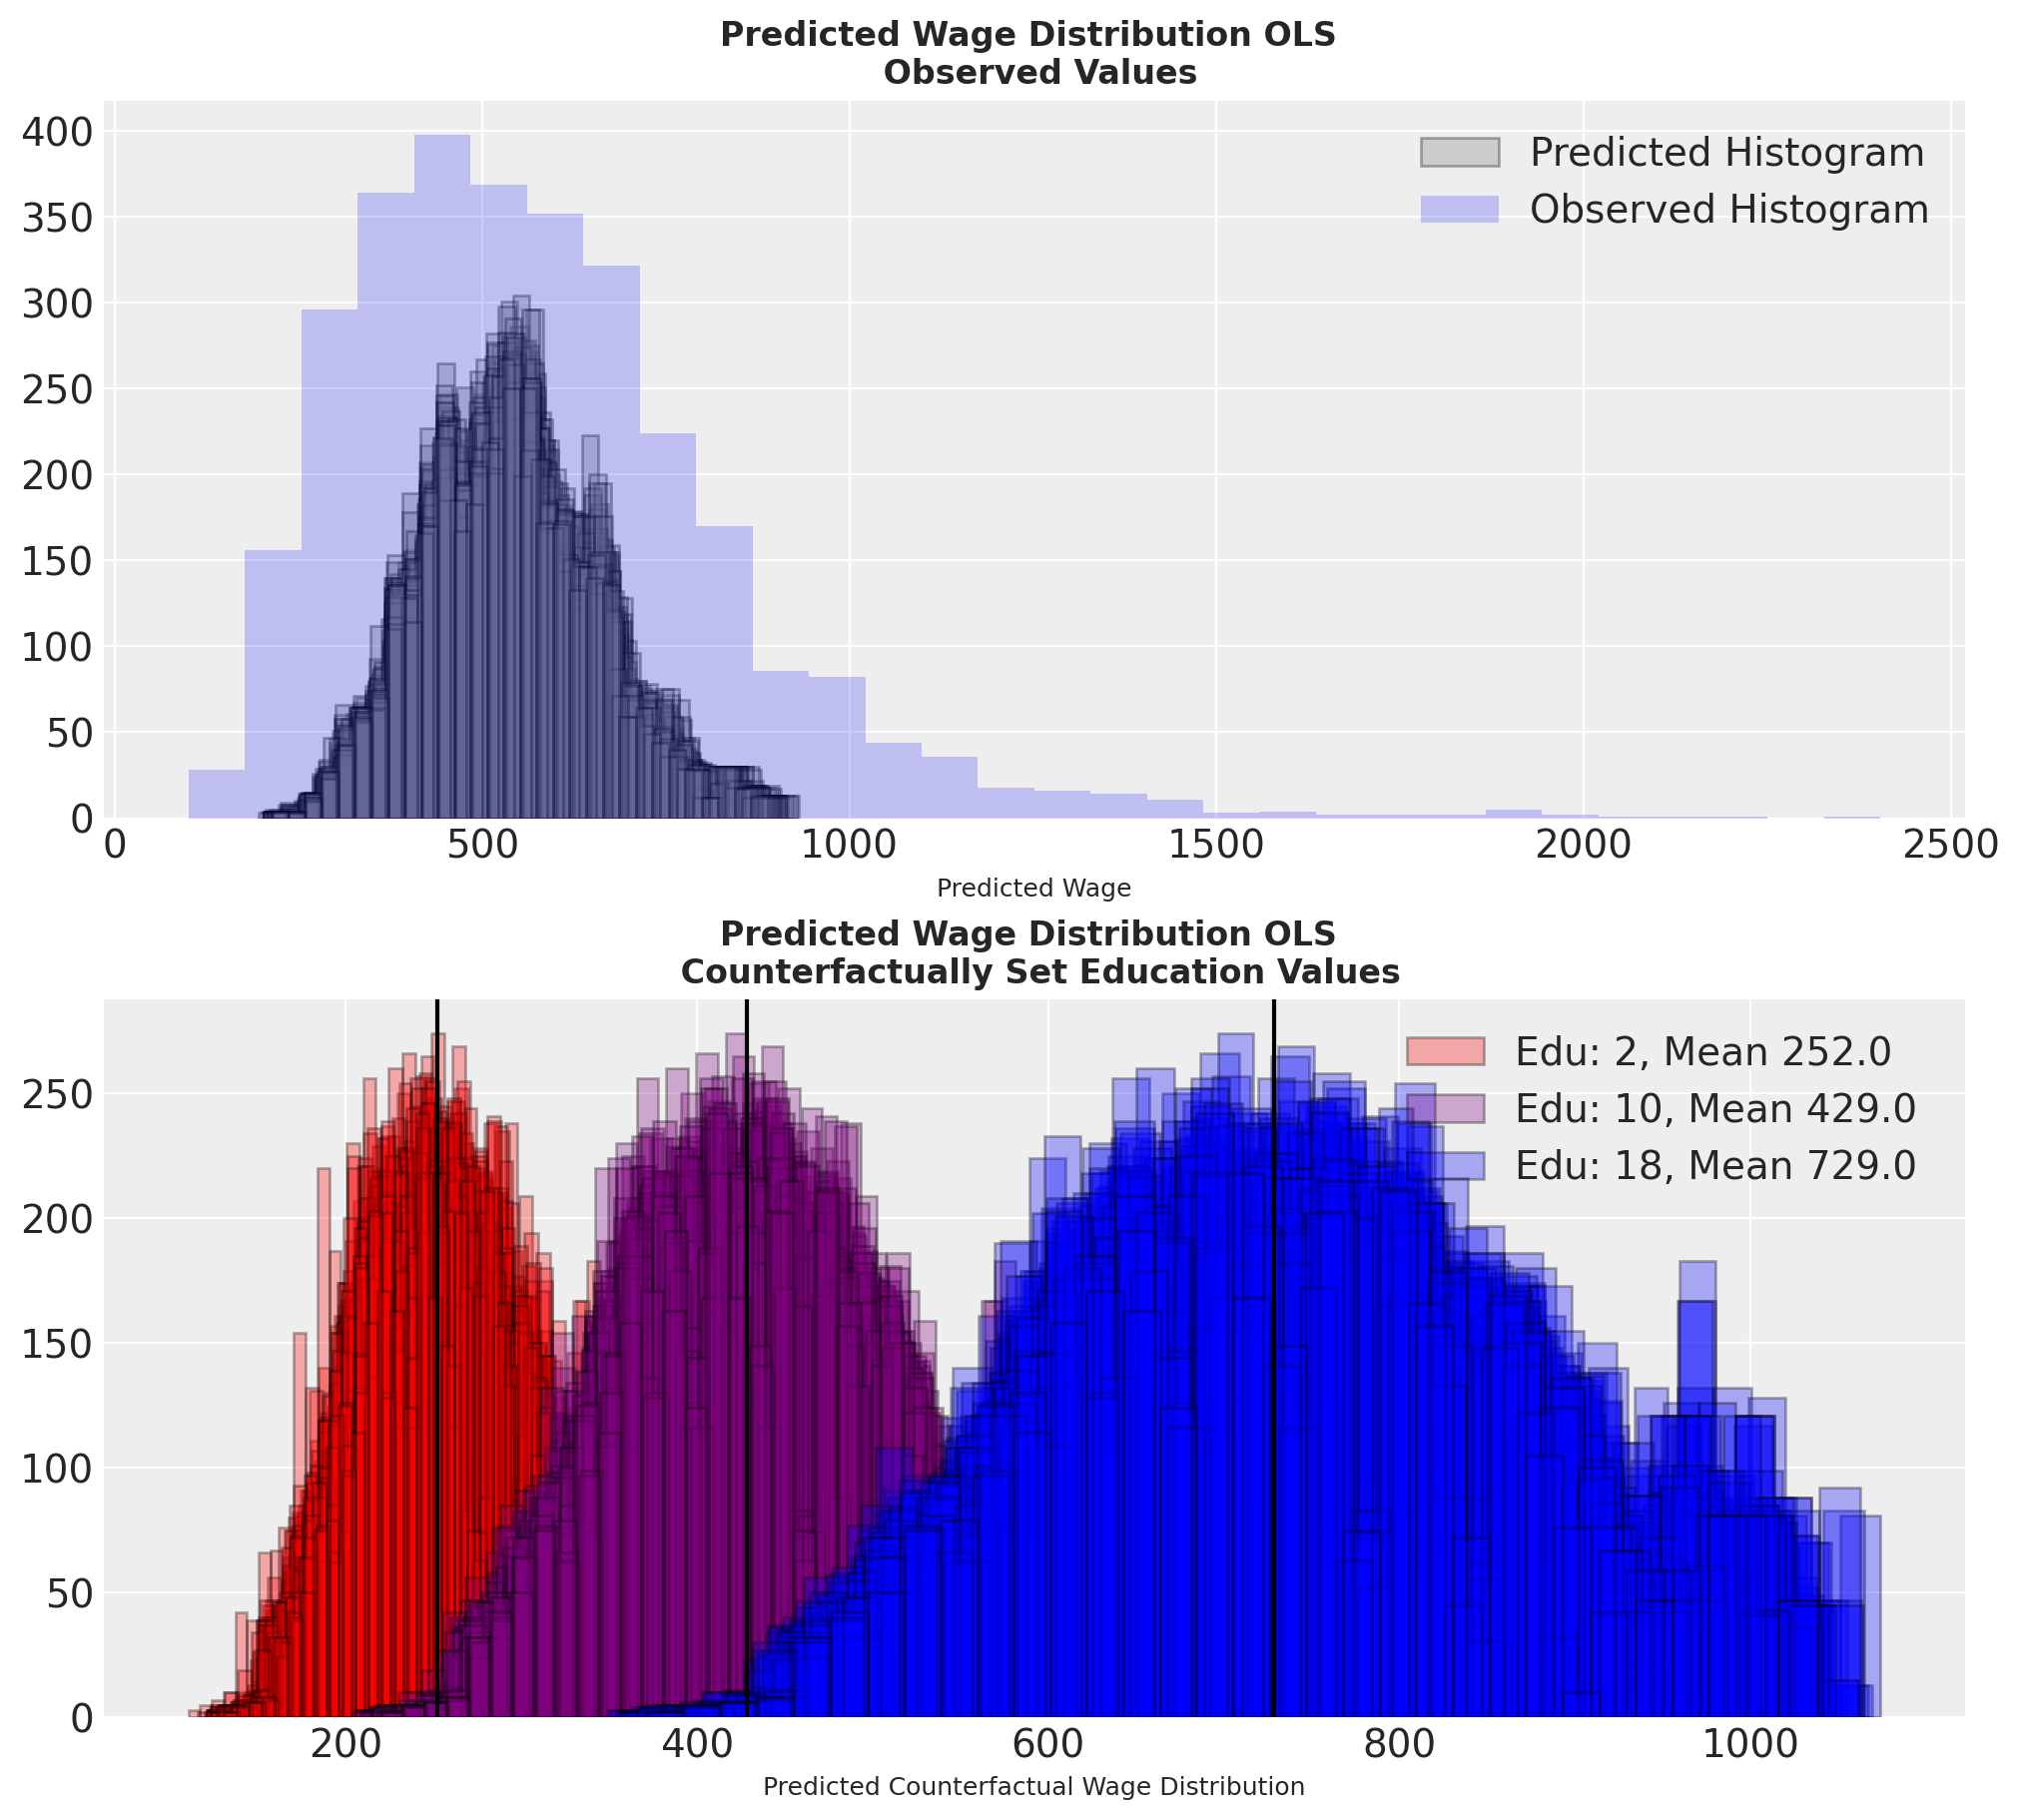

In [31]:
def make_compare_plot(iv, y, model_name, covariates):
    data = df.copy()
    data["Intercept"] = 1
    covariate_df = data[covariates]
    params = az.extract(iv["posterior"]["beta_z"])["beta_z"]

    fig, axs = plt.subplots(2, 1, figsize=(10, 9))
    axs = axs.flatten()
    for i in range(100):
        if i == 99:
            axs[0].hist(
                np.exp(np.dot(covariate_df, params[:, i].T)),
                alpha=0.3,
                bins=30,
                ec="black",
                color="grey",
                rasterized=True,
                label="Predicted Histogram",
            )
        else:
            axs[0].hist(
                np.exp(np.dot(covariate_df, params[:, i].T)),
                alpha=0.3,
                bins=30,
                ec="black",
                color="grey",
                rasterized=True,
            )
    axs[0].set_title(
        f"Predicted Wage Distribution {model_name} \n Observed Values",
        fontsize=12,
        fontweight="bold",
    )
    axs[0].hist(np.exp(y), bins=30, alpha=0.2, color="blue", label="Observed Histogram")
    axs[0].set_xlabel("Predicted Wage", fontsize=9)
    axs[0].legend()
    for c, ed in zip(["red", "purple", "blue"], [2, 10, 18]):
        temp = covariate_df.copy()
        temp["education"] = ed
        means = []
        for i in range(100):
            dist = np.exp(np.dot(temp, params[:, i].T))
            means.append(np.mean(dist))
            if i == 99:
                axs[1].hist(
                    dist,
                    alpha=0.3,
                    bins=30,
                    ec="black",
                    color=c,
                    rasterized=True,
                    label=f"Edu: {ed}, Mean {np.round(np.mean(means))} ",
                )
            else:
                axs[1].hist(
                    dist, alpha=0.3, bins=30, ec="black", color=c, rasterized=True
                )
        axs[1].axvline(np.mean(means), color="k", rasterized=True)
    axs[1].set_title(
        f"Predicted Wage Distribution {model_name} \n Counterfactually Set Education Values",
        fontsize=12,
        fontweight="bold",
    )
    axs[1].set_xlabel("Predicted Counterfactual Wage Distribution", fontsize=9)
    axs[1].legend()


covariates = list(idata_reg["posterior"]["beta_z"]["covariates"].values)
make_compare_plot(idata_reg, data["log_wage"], "OLS", covariates)

Here we see the simple regression implications under the counterfactual setting where each individual in the data set has their educational attainment set to 2, 10, 18 years respectively. The differences in expectations is then plotted. Next we show the same for the candidate IV model.

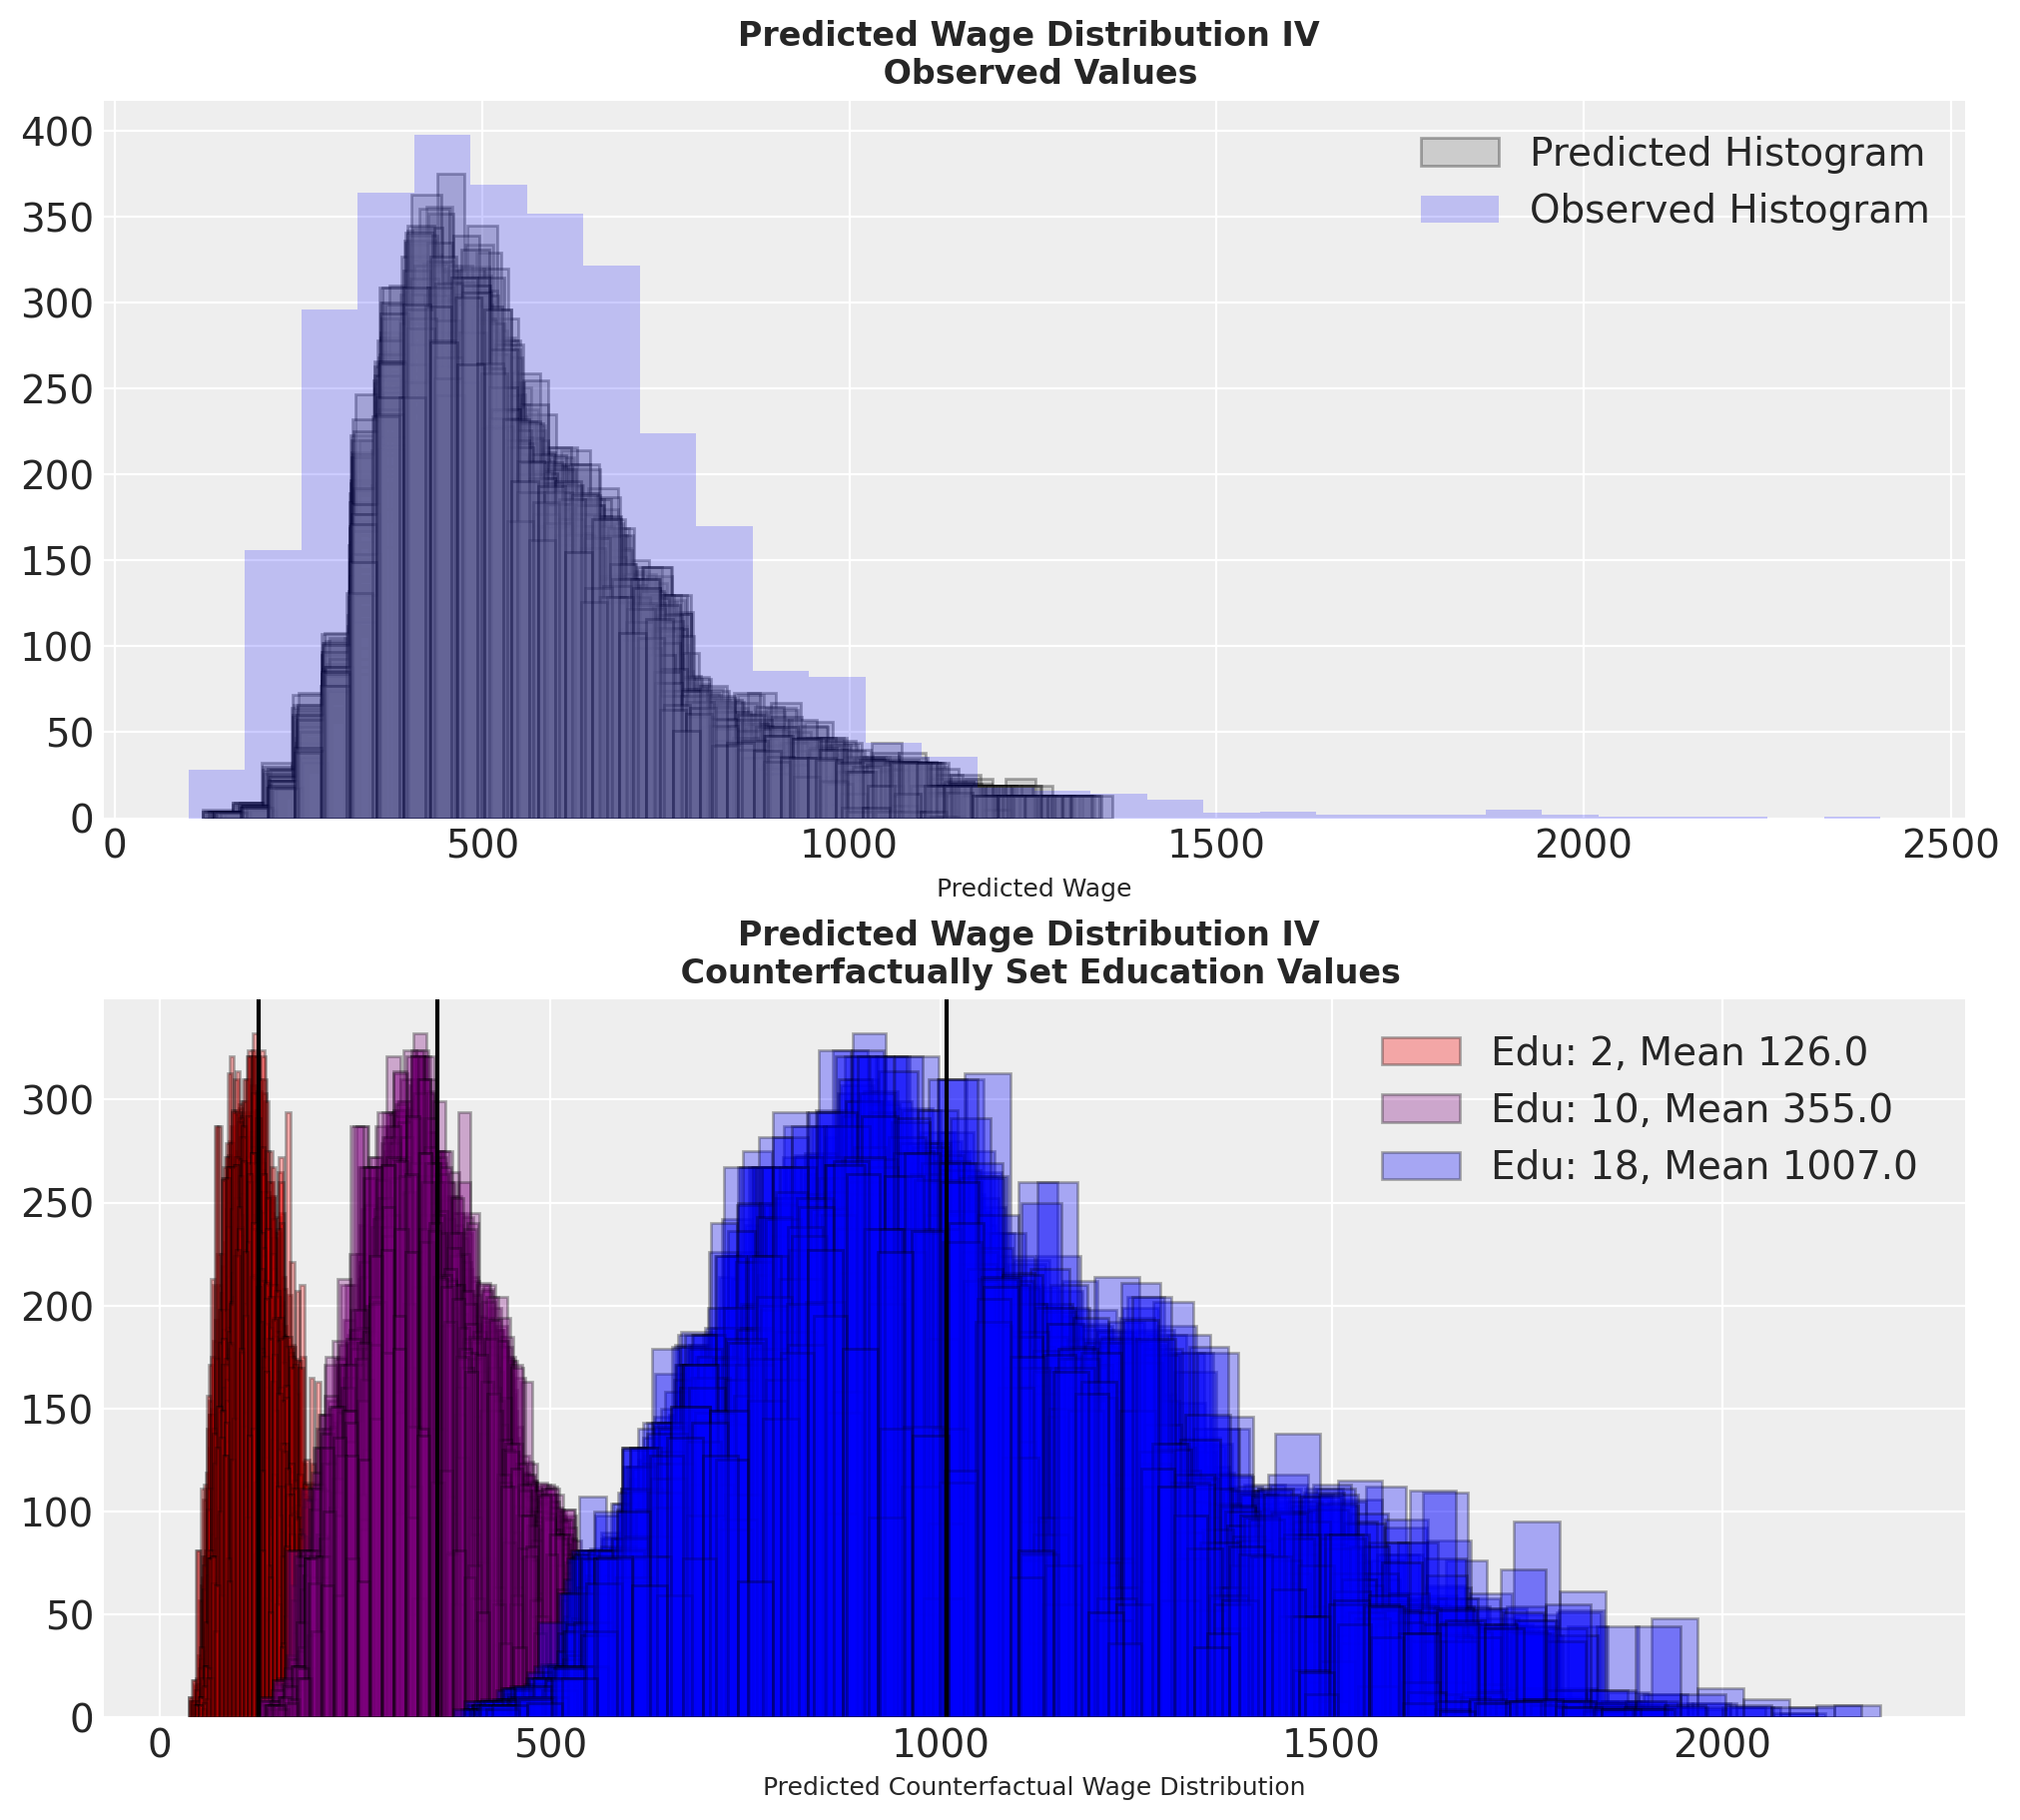

In [32]:
covariates = list(iv.idata["posterior"]["beta_z"]["covariates"].values)
make_compare_plot(iv.idata, data["log_wage"], "IV", covariates)

Here we see a stark difference in the shape of the implied distributions, and a far better recovery of the observed data in the posterior predictive plot. 

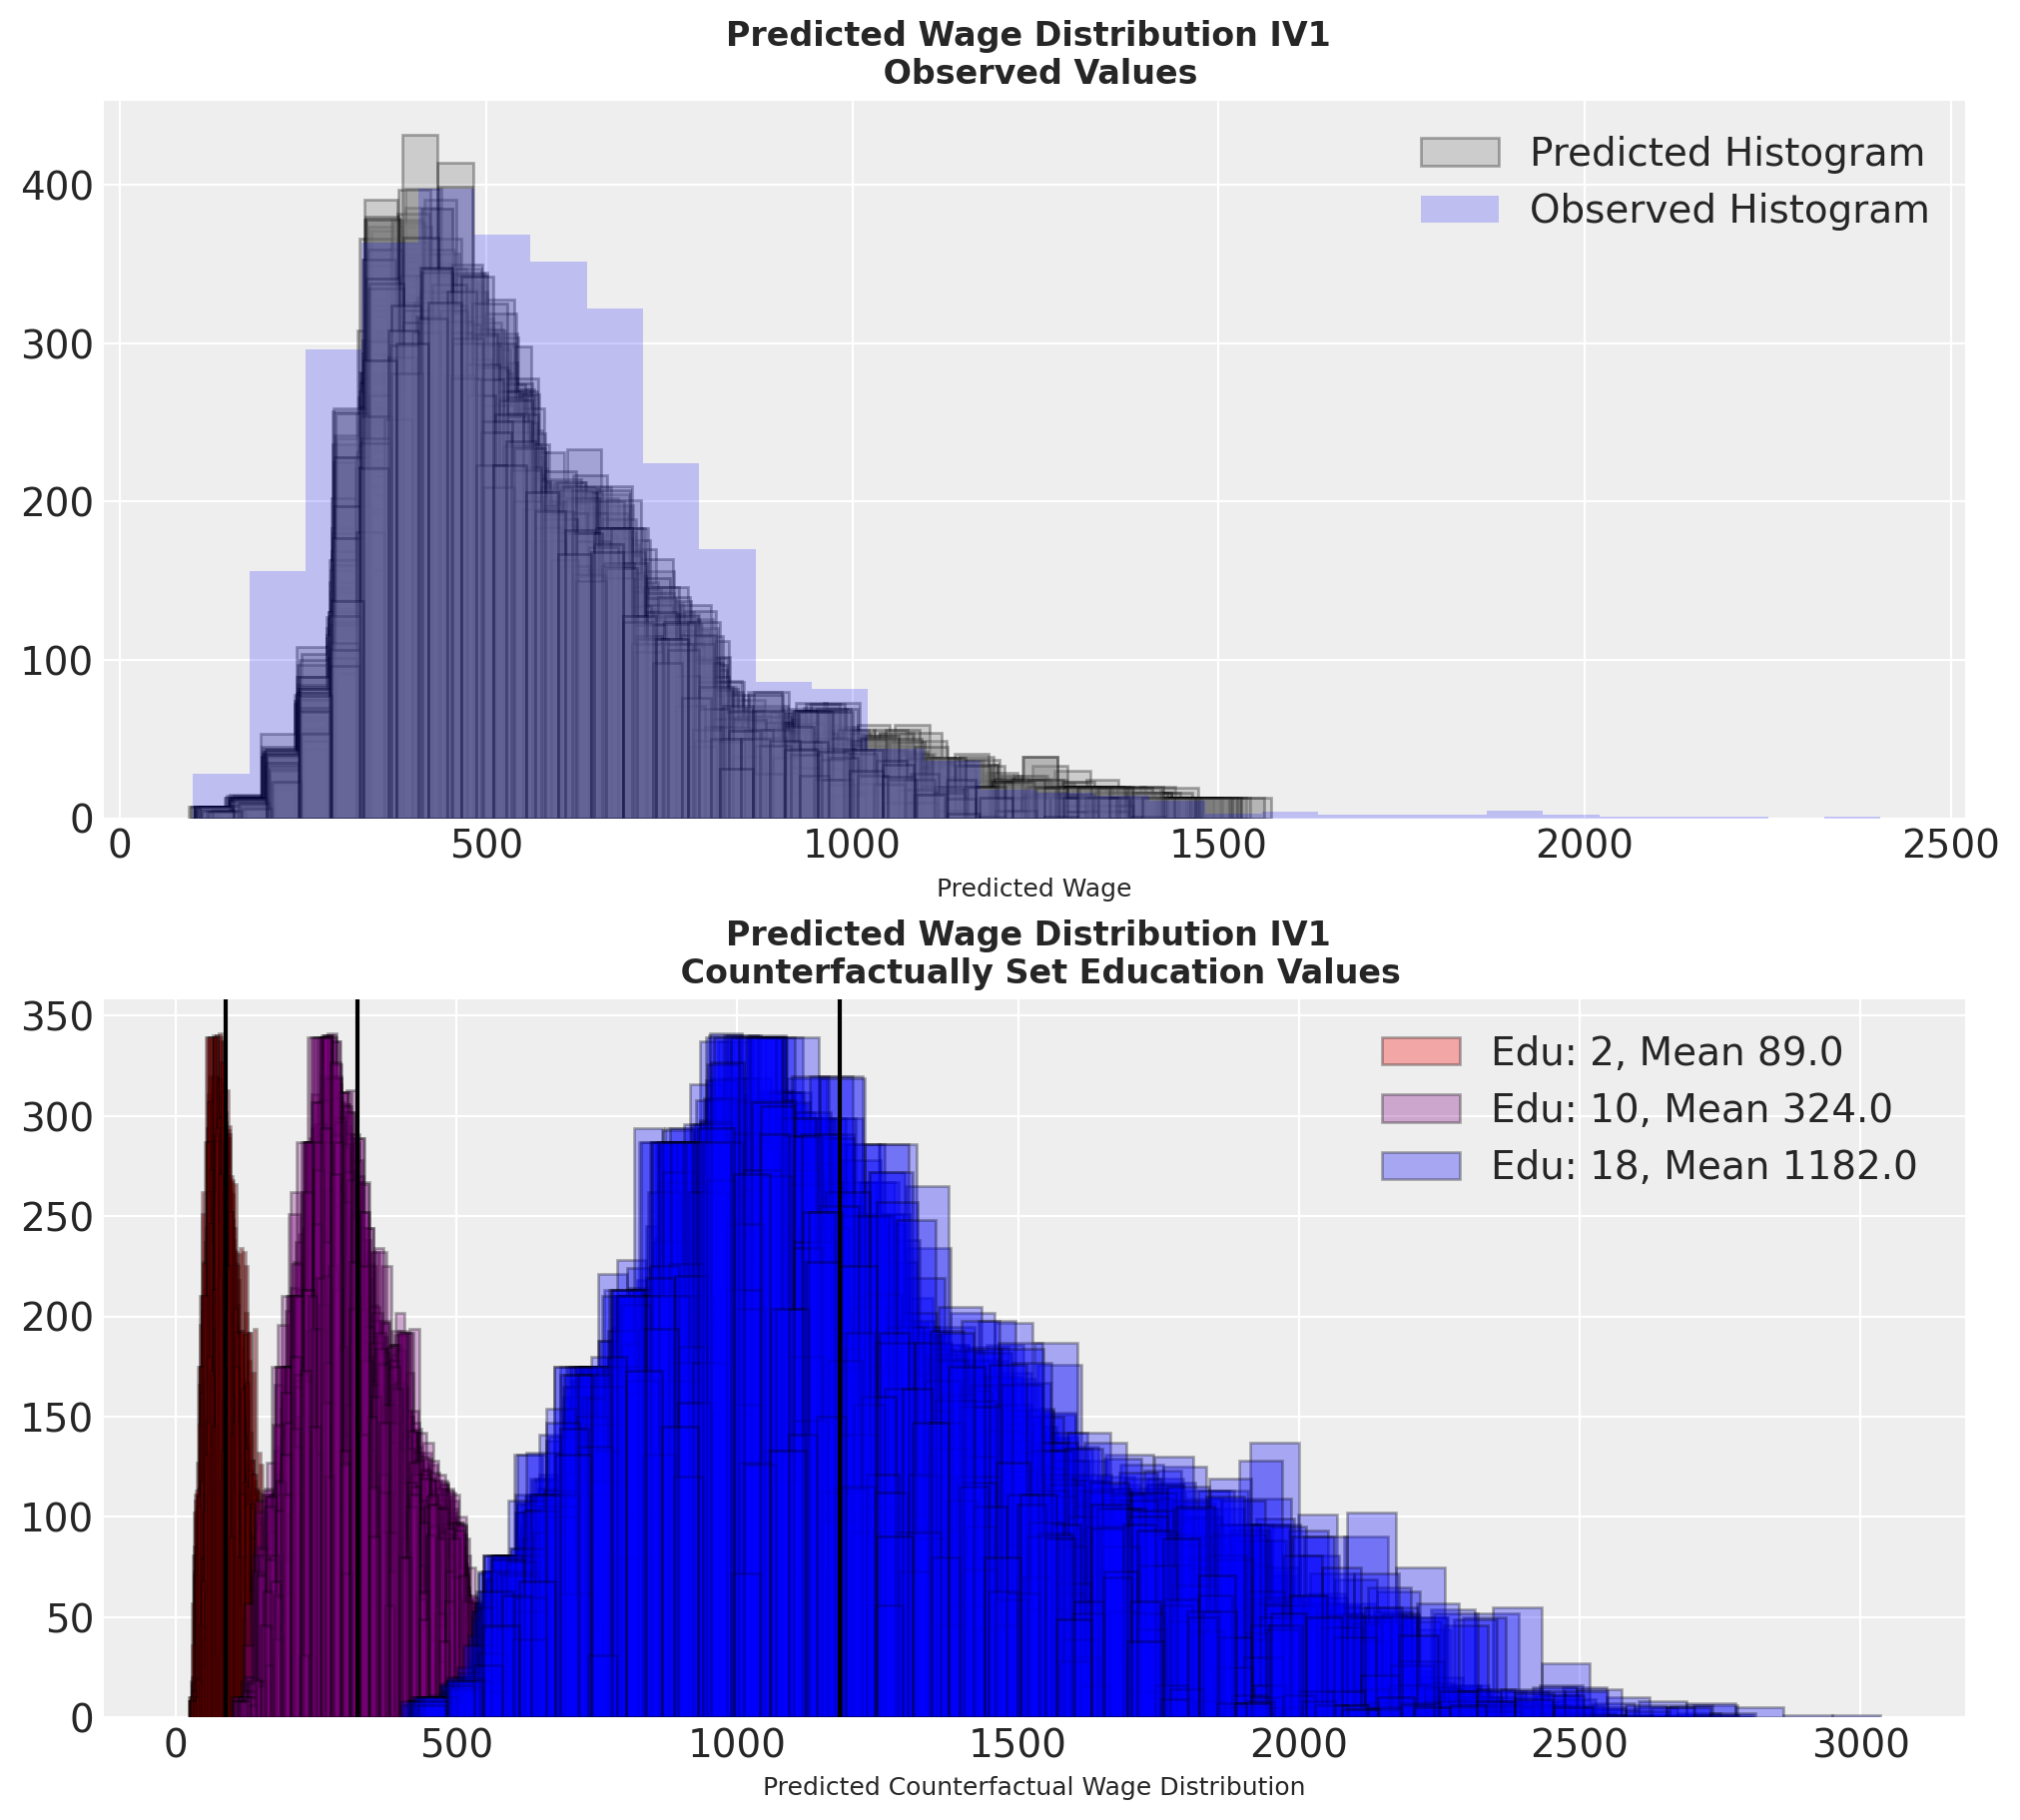

In [33]:
covariates = list(iv1.idata["posterior"]["beta_z"]["covariates"].values)
make_compare_plot(iv1.idata, data["log_wage"], "IV1", covariates)

Our second IV model shows a similar story to the first with improved coverage of the long-tail features of the log-wage distribution.

In [34]:
covariates = list(iv2.idata["posterior"]["beta_z"]["covariates"].values)
make_compare_plot(iv2.idata, data["log_wage"], "IV2", covariates)

Our final model shows a somewhat chaotic realisations of the predicted and counterfactual distributions suggesting it is not in fact a great model for our data. We can also formalise this model comparison in their predictive power.

In [35]:
compare_df = az.compare({"IV": iv.idata, "IV1": iv1.idata, "IV2": iv2.idata})
compare_df[["rank", "elpd_loo", "p_loo", "elpd_diff", "weight"]]

rank     elpd_loo      p_loo  elpd_diff    weight
IV1     0 -7586.721014  15.200967   0.000000  0.775597
IV      1 -7588.298176  14.239717   1.577163  0.224403
IV2     2 -7590.151758  15.418895   3.430744  0.000000

The final analysis should be driven by the plausibility of the implications on the raw `wage` scale. But it's useful to know how and whether a particular model fit compares in predictive power against other reasonable candidate models. 

### Conclusion

In this demonstration we've seen an example of IV regression justification conducted in a Bayesian setting. Crucially we've tried to convey the centrality of argument and model justification that is required in this mode of causal inference. These requirements are true whether you're fitting the IV model with a frequentist model or a Bayesian model, but the process of justification and model-credibility-comparison is neatly phrased in the routine of Bayesian model workflow. 

More fundamentally, in IV we are estimating a __local__ average treatment effect, a different one for each set of compliers. As we vary instruments we vary the set of compliers. By default the problem posed is one of model-uncertainty - any single IV model only tells part of the story. Each can be argued for, but a clear picture of the effect of our treatment emerges only when our estimate is broadly consistent over multiple well motivated models. Credibility accrues more to the emerging literature than any single study, this is particularly true in the case of instrumental variable designs.    

### References
:::{bibliography}
:filter: docname in docnames
:::